## Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# lib manipulation data
import pandas as pd

# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Akuisisi Data

In [3]:
# load dataset
dataset = data_hotspot("dataset_enso.csv")
dataset

,acq_date,hotspot,sst_std,sst_anom,oni_std,oni_anom,soi_std,soi_anom
0,2001-01-31,3,25.81,-0.76,25.88,-0.68,1.0,1.6
1,2001-02-28,5,26.18,-0.56,26.26,-0.52,1.7,2.8
2,2001-03-31,10,26.86,-0.37,26.76,-0.44,0.9,1.5
3,2001-04-30,20,27.24,-0.56,27.25,-0.34,0.2,0.3
4,2001-05-31,39,27.42,-0.46,27.49,-0.25,-0.5,-0.8
...,...,...,...,...,...,...,...,...
271,2023-08-31,186,28.20,1.30,28.28,1.32,-0.8,-1.4
272,2023-09-30,2247,28.29,1.53,28.32,1.56,-1.3,-2.1
273,2023-10-31,3200,28.36,1.59,28.49,1.78,-0.5,-0.8
274,2023-11-30,390,28.72,1.90,28.60,1.92,-0.8,-1.3


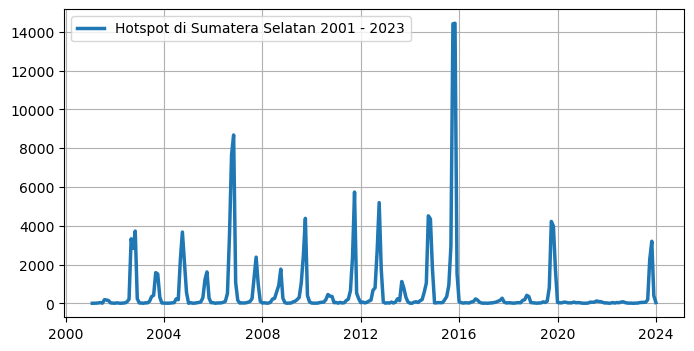

In [4]:
# hasil load dataset
lineplot1(dataset["acq_date"], dataset["hotspot"], "Hotspot di Sumatera Selatan 2001 - 2023")

### 2. Praproses Data

In [5]:
# proses normalisasi min-max
scaler, scaled = normalized(dataset, ["hotspot"])

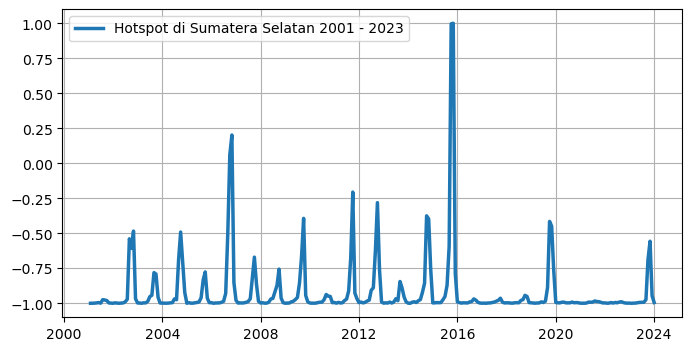

In [6]:
# hasil normalisasi min-max
lineplot1(dataset["acq_date"], np.array(scaled), "Hotspot di Sumatera Selatan 2001 - 2023")

### 3. Pembagian Data

In [7]:
# proses pembagian data
train_data, test_data = splitting(scaled)

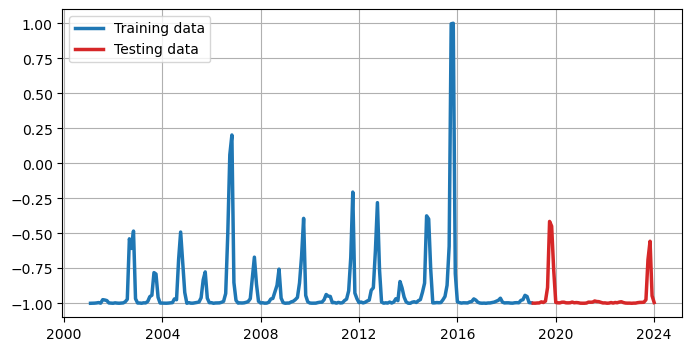

In [8]:
# hasil pembagian data
lineplot2(
  x1=dataset.iloc[0:len(train_data),0], y1=train_data, label1="Training data",
  x2=dataset.iloc[len(train_data):len(dataset),0], y2=test_data, label2="Testing data",
)

### 4. Supervised Learning

In [9]:
# function for supervised learning
x_train, y_train, x_test, y_test = results_supervised_learning(train_data, test_data)

In [10]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(215, 1, 1) (215,)


In [11]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 1) (59,)


### 5.1 Modeling SBi-LSTM

- SBi-LSTM

In [12]:
# call models LSTM
lstm_model = get_models(
  algorithm="SBi-LSTM",
  timestep=x_train.shape[1],
  activation="selu",
  dropout=0.25,
  optimizer="sgd"
)

In [13]:
# compile models
lstm_history, lstm_predictions = get_predictions(
  model=lstm_model,
  x_train=x_train, y_train=y_train,
  x_test=x_test, y_test=y_test,
  batch_size=8, epochs=1500
)

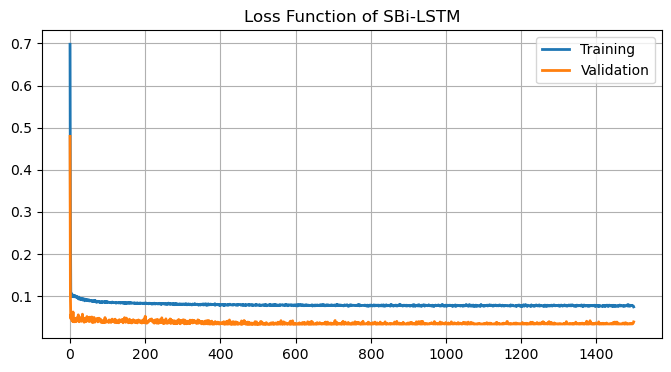

In [14]:
# show loss function
lineplot3(
  training=lstm_history.history['loss'],
  validation=lstm_history.history['val_loss'],
  title="Loss Function of SBi-LSTM"
)

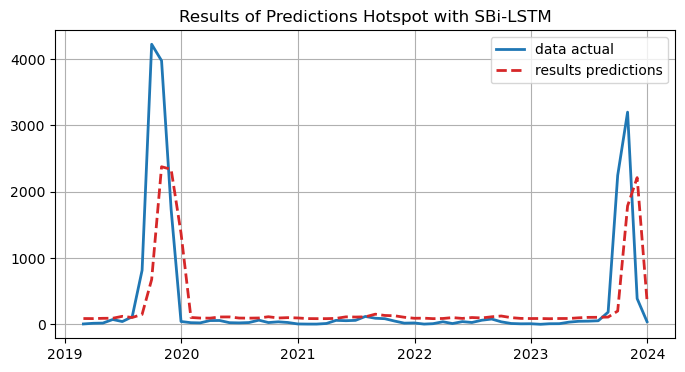

In [15]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=inverse(scaler, y_test),
  ypred=inverse(scaler, lstm_predictions),
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [16]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(inverse(scaler, y_test), inverse(scaler, lstm_predictions))

# show eror
print("Evaluate Models with : "+str("SBi-LSTM"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-LSTM
-------------------------------
R       : 0.6452
P-value : 0.0
MAE     : 280.9534
RMSE    : 683.1384
MAPE    : 4.2223


- SBi-LSTM + XGBoost

In [17]:
# call models XGBoost
xgb_predictions = get_XGBoost(
  xtrue=x_test,
  ytrue=y_test,
  ypred=lstm_predictions
)

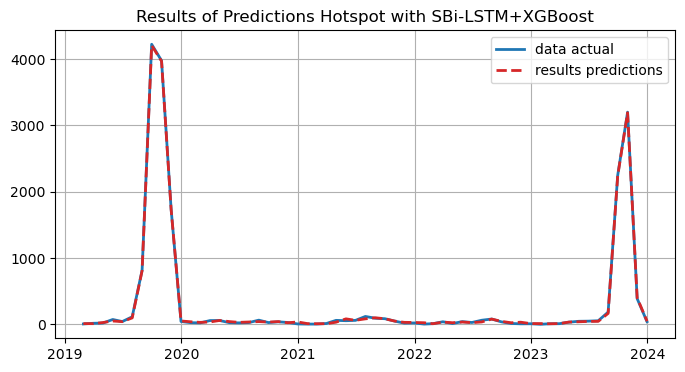

In [18]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=inverse(scaler, y_test),
  ypred=inverse(scaler, xgb_predictions),
  title="Results of Predictions Hotspot with SBi-LSTM+XGBoost"
)

In [19]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(inverse(scaler, y_test), inverse(scaler, xgb_predictions))

# show eror
print("Evaluate Models with : "+str("SBi-LSTM+XGBoost"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-LSTM+XGBoost
-------------------------------
R       : 0.9999
P-value : 0.0
MAE     : 9.9617
RMSE    : 13.1814
MAPE    : 0.4499


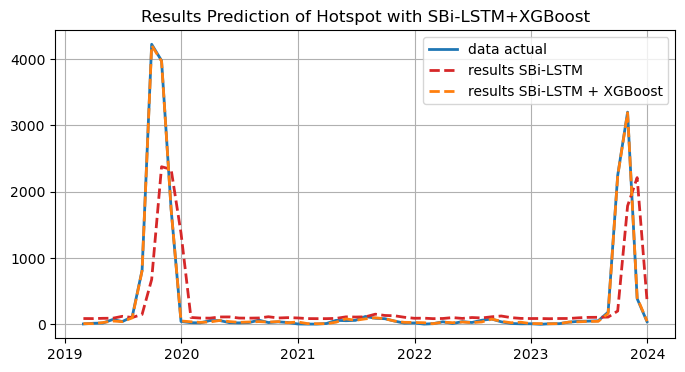

In [20]:
# show result predictions
lineplot5(

  # sumbu x
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),

  # data actual
  ytrue=inverse(scaler, y_test),

  # hasil SBi-LSTM
  ypred1=inverse(scaler, lstm_predictions),
  label1="results SBi-LSTM",
  
  # hasil SBi-LSTM-XGBoost
  ypred2=inverse(scaler, xgb_predictions),
  label2="results SBi-LSTM + XGBoost",

  # title
  title="Results Prediction of Hotspot with SBi-LSTM+XGBoost"
)

### 5.2 Modeling SBi-GRU

- SBi-GRU

In [21]:
# call models GRU
gru_model = get_models(
  algorithm="SBi-GRU",
  timestep=x_train.shape[1],
  activation="selu",
  dropout=0.25,
  optimizer="sgd"
)

In [22]:
# compile models
gru_history, gru_predictions = get_predictions(
  model=gru_model,
  x_train=x_train, y_train=y_train,
  x_test=x_test, y_test=y_test,
  batch_size=8, epochs=1500
)

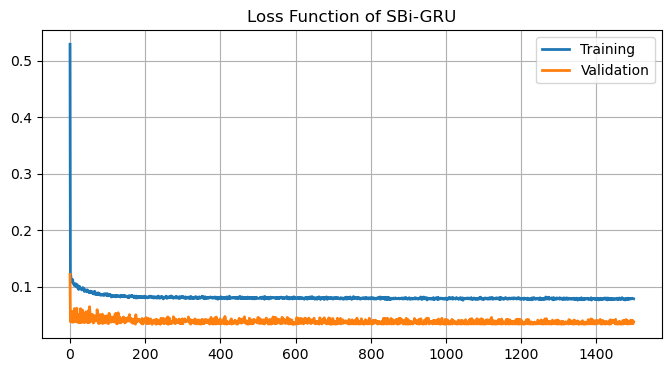

In [23]:
# show loss function
lineplot3(
  training=gru_history.history['loss'],
  validation=gru_history.history['val_loss'],
  title="Loss Function of SBi-GRU"
)

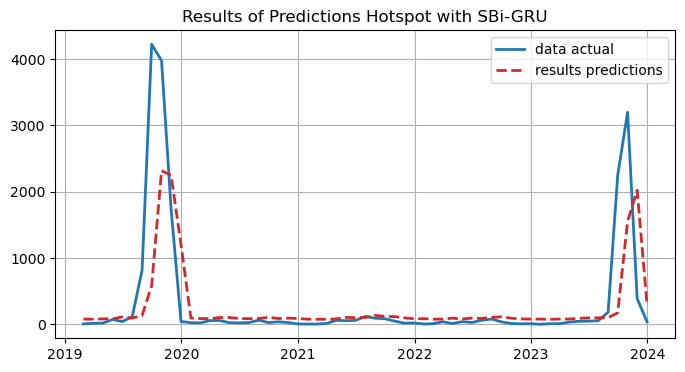

In [24]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=inverse(scaler, y_test),
  ypred=inverse(scaler, gru_predictions),
  title="Results of Predictions Hotspot with SBi-GRU"
)

In [25]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(inverse(scaler, y_test), inverse(scaler, gru_predictions))

# show eror
print("Evaluate Models with : "+str("SBi-GRU"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-GRU
-------------------------------
R       : 0.6434
P-value : 0.0
MAE     : 272.907
RMSE    : 688.5002
MAPE    : 3.7492


- SBi-GRU + XGBoost

In [26]:
# call models XGBoost
xgb_predictions = get_XGBoost(
  xtrue=x_test,
  ytrue=y_test,
  ypred=gru_predictions
)

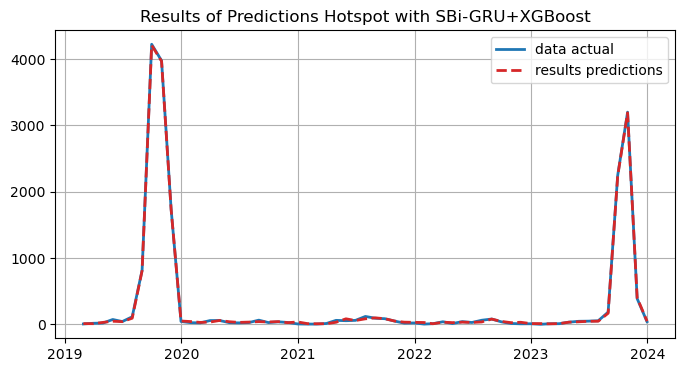

In [27]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=inverse(scaler, y_test),
  ypred=inverse(scaler, xgb_predictions),
  title="Results of Predictions Hotspot with SBi-GRU+XGBoost"
)

In [28]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(inverse(scaler, y_test), inverse(scaler, xgb_predictions))

# show eror
print("Evaluate Models with : "+str("SBi-GRU+XGBoost"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-GRU+XGBoost
-------------------------------
R       : 0.9999
P-value : 0.0
MAE     : 10.184
RMSE    : 13.5747
MAPE    : 0.4644


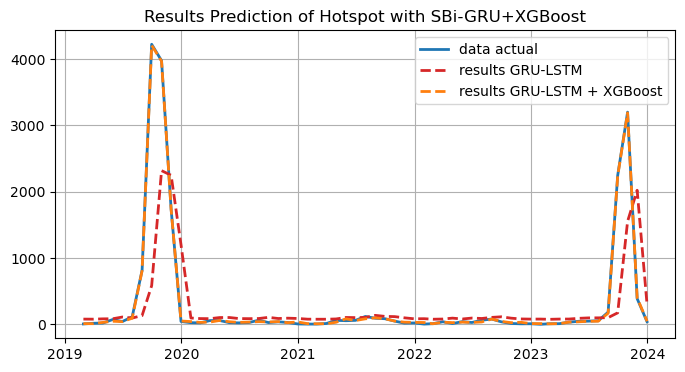

In [29]:
# show result predictions
lineplot5(

  # sumbu x
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  
  # data actual
  ytrue=inverse(scaler, y_test),

  # hasil SBi-GRU
  ypred1=inverse(scaler, gru_predictions),
  label1="results GRU-LSTM",
  
  # hasil SBi-GRU-XGBoost
  ypred2=inverse(scaler, xgb_predictions),
  label2="results GRU-LSTM + XGBoost",

  # title
  title="Results Prediction of Hotspot with SBi-GRU+XGBoost"
)